## Homework 2: RNN
Problem 1: Text Generation (fake reviews) Text generation serves various purposes like machine translation, chatbots, virtual assistants, and AIGC. To understand the text generation process with a language model, consider it as an iterative approach. Initially, we predict the first word from the input sequence and subsequently use that predicted word in the input to generate the second word. Repeat the process until done.

If we recall, we focused on letter generation in class. Now, using the review data in HW1, let's build upon the in-class examples to create a simulated review using a GRU or LSTM model. For simplicity's sake, let's concentrate on coding the training process without delving into hyperparameter tuning or model evaluations. We'll generate both a negative review (combining 1-star, 2-star, and 3-star comments) and a positive review (utilizing 4-star and 5-star comments). Essentially, our goal is to generate tokens instead of individual letters.

# Negative reviews next word prediction

In [65]:
# import google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Read the Amazon comments data

In [67]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string


import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
# import nltk
# nltk.download('all')

In [68]:
os.chdir('/content/drive/MyDrive/Text Analytics/HW2')

In [69]:
df = pd.read_csv('Amazon_Comments.csv',  delimiter="^", header=None, names=["No", "Title", "Date", "Bool", "Review", "Rating"])

df = df.reset_index(drop=True)

df.set_index('No', inplace=True)

df.head()

,Title,Date,Bool,Review,Rating
No,,,,,
1,These are hands down the best quality bands fo...,2016-01-16,False,These are hands down the best quality bands f...,5.0
2,High Quality Bands,2016-01-22,False,I just got this set yesterday as well as a se...,5.0
3,Five Stars,2015-12-27,False,My husband uses these and finds them to be go...,5.0
4,The resistance is great. I would agree that th...,2016-01-13,False,I got these for Christmas and have been using...,4.0
5,Good quality product,2016-01-20,False,Haven\t had it long enough to use all of the ...,5.0


In [70]:
# Drop Title, date, bool from df

df1 = df.copy()

df1.drop(columns=['Title', 'Date', 'Bool'], inplace=True)

df1.head()

,Review,Rating
No,,
1,These are hands down the best quality bands f...,5.0
2,I just got this set yesterday as well as a se...,5.0
3,My husband uses these and finds them to be go...,5.0
4,I got these for Christmas and have been using...,4.0
5,Haven\t had it long enough to use all of the ...,5.0


### Visualize the frequency distribution of Ratings

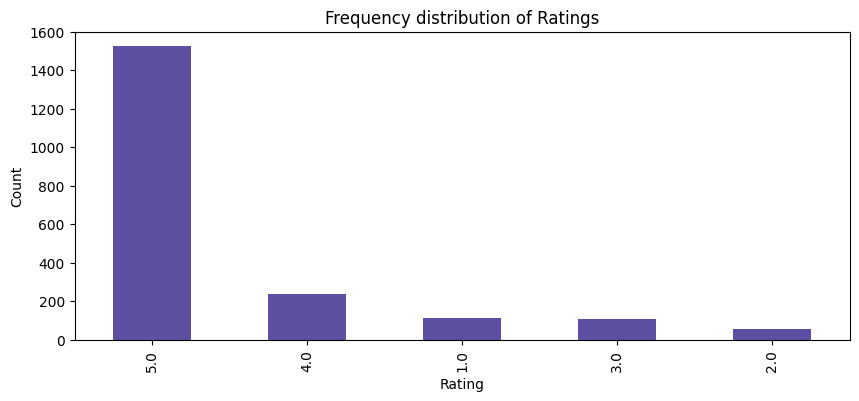

In [78]:
# Visualize the frequency distribution of Ratings

df1['Rating'].value_counts().plot(kind='bar', colormap="Spectral_r", figsize=(10,4))
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Frequency distribution of Ratings')
plt.show()


#### The highest number of ratings in the Amazon review data consist of 5 star ratings followed by 4 star and 1 star ratings respectively.

## Label the data as positive and negative

In [71]:
# Add sentiment column -- If Rating =1 or 2 or 3 then label that review as negative else Flag as Positive

df1['sentiment'] = df['Rating'].map({1.0: 'Negative', 2.0: 'Negative', 3.0: 'Negative', 4.0: 'Positive', 5.0: 'Positive'})
df1

,Review,Rating,sentiment
No,,,
1,These are hands down the best quality bands f...,5.0,Positive
2,I just got this set yesterday as well as a se...,5.0,Positive
3,My husband uses these and finds them to be go...,5.0,Positive
4,I got these for Christmas and have been using...,4.0,Positive
5,Haven\t had it long enough to use all of the ...,5.0,Positive
...,...,...,...
2034,Just l like Nonna\s!,5.0,Positive
2035,Works great!,5.0,Positive
2036,very good,5.0,Positive


In [72]:
# Label the positive sentiment as 1 and negative sentiment as 0

df1['Label'] = df1['sentiment'].map({'Positive': 1, 'Negative': 0})
df1

,Review,Rating,sentiment,Label
No,,,,
1,These are hands down the best quality bands f...,5.0,Positive,1
2,I just got this set yesterday as well as a se...,5.0,Positive,1
3,My husband uses these and finds them to be go...,5.0,Positive,1
4,I got these for Christmas and have been using...,4.0,Positive,1
5,Haven\t had it long enough to use all of the ...,5.0,Positive,1
...,...,...,...,...
2034,Just l like Nonna\s!,5.0,Positive,1
2035,Works great!,5.0,Positive,1
2036,very good,5.0,Positive,1


## Visualize the distribution of the Sentiment

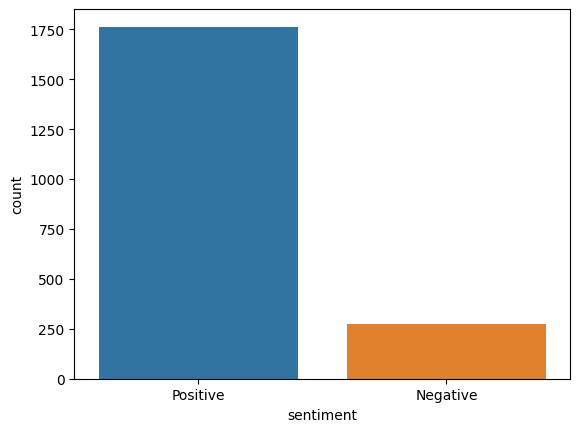

In [10]:
# Visualize a count plot for the sentiment column with sns.countplot

import seaborn as sns
sns.countplot(x='sentiment', data=df1)
plt.show()


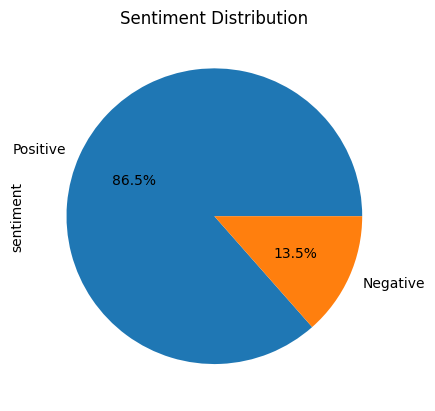

In [11]:
# Visualize a pie chart for the sentiment column

df1.sentiment.value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Sentiment Distribution')
plt.show()

## Data Cleaning

In [12]:
# Clean the review data

# Function to clean and preprocess text
def clean_text(text):

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])


    # Tokenize text
    tokens = nltk.word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))

    tokens = [word for word in tokens if word not in stop_words and not word.isdigit()]

    #Stemming (you can replace with lemmatization if preferred)
    #stemmer = PorterStemmer()

    #tokens = [stemmer.stem(word) for word in tokens]

    # Create a lemmatizer object.
    lemmatizer = WordNetLemmatizer()

   #Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Reconstruct cleaned text
    cleaned_text = ' '.join(tokens)

    return cleaned_text

In [13]:
# Apply the clean_text function to each review in the DataFrame

df2 = df1.copy()

df2['Clean_Review'] = df1['Review'].apply(clean_text)

# Print the cleaned reviews

df2.head()

,Review,Rating,sentiment,Label,Clean_Review
No,,,,,
1,These are hands down the best quality bands f...,5.0,Positive,1,hand best quality band money year old male wan...
2,I just got this set yesterday as well as a se...,5.0,Positive,1,got set yesterday well set another company cou...
3,My husband uses these and finds them to be go...,5.0,Positive,1,husband us find good arthritis stretching exer...
4,I got these for Christmas and have been using...,4.0,Positive,1,got christmas using multiple day week since re...
5,Haven\t had it long enough to use all of the ...,5.0,Positive,1,havent long enough use component far im impres...


In [14]:
# Generate tokens for Clean_Review

df2['Clean_review_Tokens'] = df2['Clean_Review'].apply(nltk.word_tokenize)

df2

,Review,Rating,sentiment,Label,Clean_Review,Clean_review_Tokens
No,,,,,,
1,These are hands down the best quality bands f...,5.0,Positive,1,hand best quality band money year old male wan...,"[hand, best, quality, band, money, year, old, ..."
2,I just got this set yesterday as well as a se...,5.0,Positive,1,got set yesterday well set another company cou...,"[got, set, yesterday, well, set, another, comp..."
3,My husband uses these and finds them to be go...,5.0,Positive,1,husband us find good arthritis stretching exer...,"[husband, us, find, good, arthritis, stretchin..."
4,I got these for Christmas and have been using...,4.0,Positive,1,got christmas using multiple day week since re...,"[got, christmas, using, multiple, day, week, s..."
5,Haven\t had it long enough to use all of the ...,5.0,Positive,1,havent long enough use component far im impres...,"[havent, long, enough, use, component, far, im..."
...,...,...,...,...,...,...
2034,Just l like Nonna\s!,5.0,Positive,1,l like nonnas,"[l, like, nonnas]"
2035,Works great!,5.0,Positive,1,work great,"[work, great]"
2036,very good,5.0,Positive,1,good,[good]


## Filter the Negative Reviews Data

In [20]:
# Subset the negative sentiment data

negative_df = df2[df2['sentiment'] == 'Negative']
negative_df

,Review,Rating,sentiment,Label,Clean_Review,Clean_review_Tokens
No,,,,,,
13,"They tore up after a little over a year, and ...",1.0,Negative,0,tore little year im strong poor quality also o...,"[tore, little, year, im, strong, poor, quality..."
29,"The product is good, the problem is I didn\t ...",2.0,Negative,0,product good problem didnt get yellow green ba...,"[product, good, problem, didnt, get, yellow, g..."
40,Is a good price for the quality and presentat...,3.0,Negative,0,good price quality presentation uncomfortable use,"[good, price, quality, presentation, uncomfort..."
52,The quality of the rubber band is not vey good.,2.0,Negative,0,quality rubber band vey good,"[quality, rubber, band, vey, good]"
68,"What a waste of money, first off let me state...",1.0,Negative,0,waste money first let state product may work e...,"[waste, money, first, let, state, product, may..."
...,...,...,...,...,...,...
1988,"The coffee is great, but the bottom of the ha...",3.0,Negative,0,coffee great bottom handle melted electric coi...,"[coffee, great, bottom, handle, melted, electr..."
1991,"I did not realize I was buying the 2 ounce, i...",1.0,Negative,0,realize buying ounce say one cup actually cup ...,"[realize, buying, ounce, say, one, cup, actual..."
1992,I bought it to replace my 6 cup. I didn\t rea...,3.0,Negative,0,bought replace cup didnt realize cup one arriv...,"[bought, replace, cup, didnt, realize, cup, on..."


## Unigram Token Frequency for Negative Data

In [21]:
import collections
from collections import Counter
from itertools import chain

word_tokenize = nltk.word_tokenize

# Tokenize the text column

# Print the tokenized text
corpus = negative_df['Clean_review_Tokens']
corpus = corpus.tolist()
# Flatten list of lists to a single list
tokens = list(chain(*corpus))
unique_freq = collections.Counter(tokens)
# Count each unique element
unique_freq_df = pd.DataFrame.from_dict(unique_freq, orient='index').reset_index() # Convert to dataframe
# Rename columns
unique_freq_df = unique_freq_df.rename(columns={'index': 'Token', 0: 'Count'})
# Sort by count
unique_freq_df.sort_values('Count', ascending=False, inplace=True)
unique_freq_df = unique_freq_df

unique_freq_df1 = unique_freq_df.reset_index(drop=True)
unique_freq_df2 = unique_freq_df1.set_index("Token")
print(len(unique_freq_df))
unique_freq_df2

1916


,Count
Token,
one,64
work,63
use,62
filter,55
water,54
...,...
christmas,1
gifted,1
operates,1


In [22]:
# Storing the frequencies of unigrams

freq1 = unique_freq_df['Count'].reset_index(drop=True)
print(type(freq1))
freq1

<class 'pandas.core.series.Series'>


0       64
1       63
2       62
3       55
4       54
        ..
1911     1
1912     1
1913     1
1914     1
1915     1
Name: Count, Length: 1916, dtype: int64

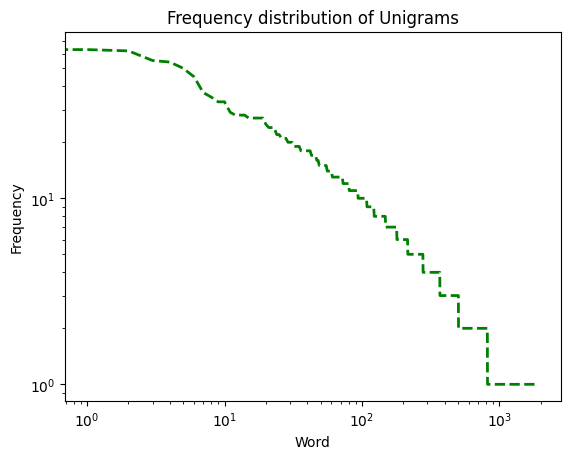

In [23]:
# Plotting the log scale of frequencies of unigrams

plt.plot(freq1, color="Green", linewidth=2, linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.title("Frequency distribution of Unigrams")
plt.show()

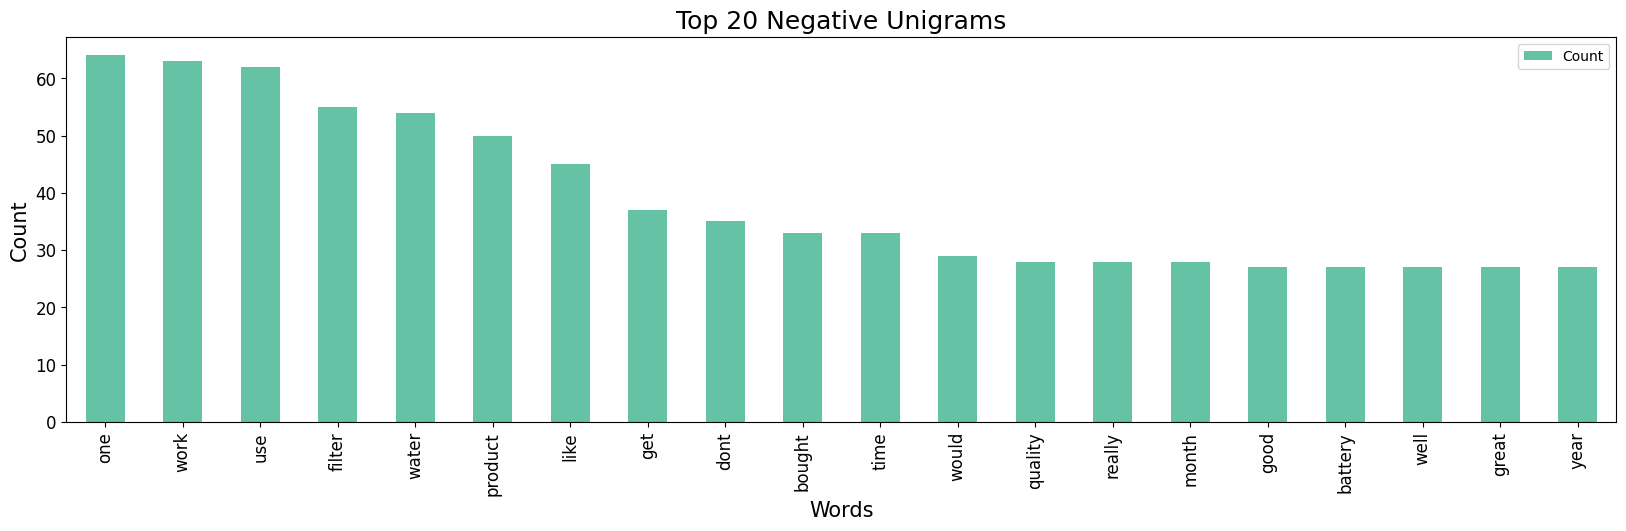

In [26]:
# Plot the df3 Unigrams

unique_freq_df2.head(20).plot(kind='bar', figsize=(20, 5), cmap="Set2")
plt.xlabel('Words', fontsize = 15)
plt.ylabel('Count', fontsize=15)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.title('Top 20 Negative Unigrams', fontsize=18)
plt.show()

## Bigram Token Frequency for Negative Data

In [27]:

# Generate bigrams from df2['Clean_review_Tokens']

bigram_list = [list(nltk.bigrams(text)) for text in negative_df['Clean_review_Tokens']]

# Create a Counter object to count the frequency of each bigram
bigram_count = collections.Counter(list(chain(*bigram_list)))

# Convert the Counter object to a DataFrame
bigram_df = pd.DataFrame.from_dict(bigram_count, orient='index').reset_index()

# Rename the columns
bigram_df = bigram_df.rename(columns={'index': 'Bigram', 0: 'Count'})

# Sort the DataFrame by frequency in descending order
bigram_df.sort_values('Count', ascending=False, inplace=True)

# Print the top 20 bigrams
bigram_df.head(20)

bigram_df1 = bigram_df.reset_index(drop=True)
bigram_df2 = bigram_df1.set_index("Bigram")
bigram_df2

,Count
Bigram,
"(dont, know)",7
"(didnt, work)",7
"(water, filter)",6
"(waffle, iron)",6
"(water, pitcher)",6
...,...
"(le, efficiently)",1
"(pop, le)",1
"(surprisingly, expensive)",1


In [28]:
# Storing the frequencies of unigrams

freq2 = bigram_df2['Count'].reset_index(drop=True)
print(type(freq2))
freq2

<class 'pandas.core.series.Series'>


0       7
1       7
2       6
3       6
4       6
       ..
5050    1
5051    1
5052    1
5053    1
5054    1
Name: Count, Length: 5055, dtype: int64

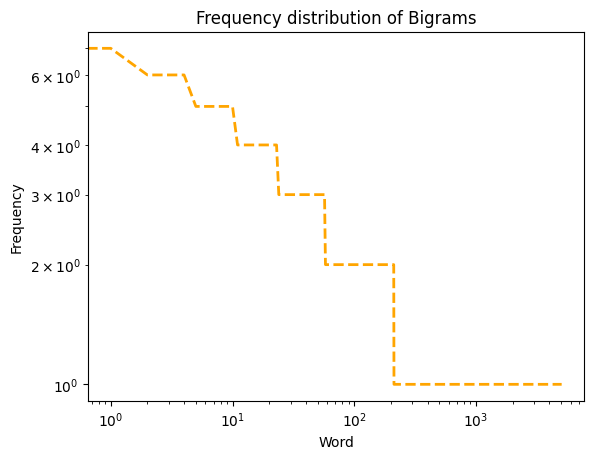

In [29]:
# Plotting the log scale of frequencies of Bigrams

plt.plot(freq2, color="Orange", linewidth=2, linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.title("Frequency distribution of Bigrams")
plt.show()

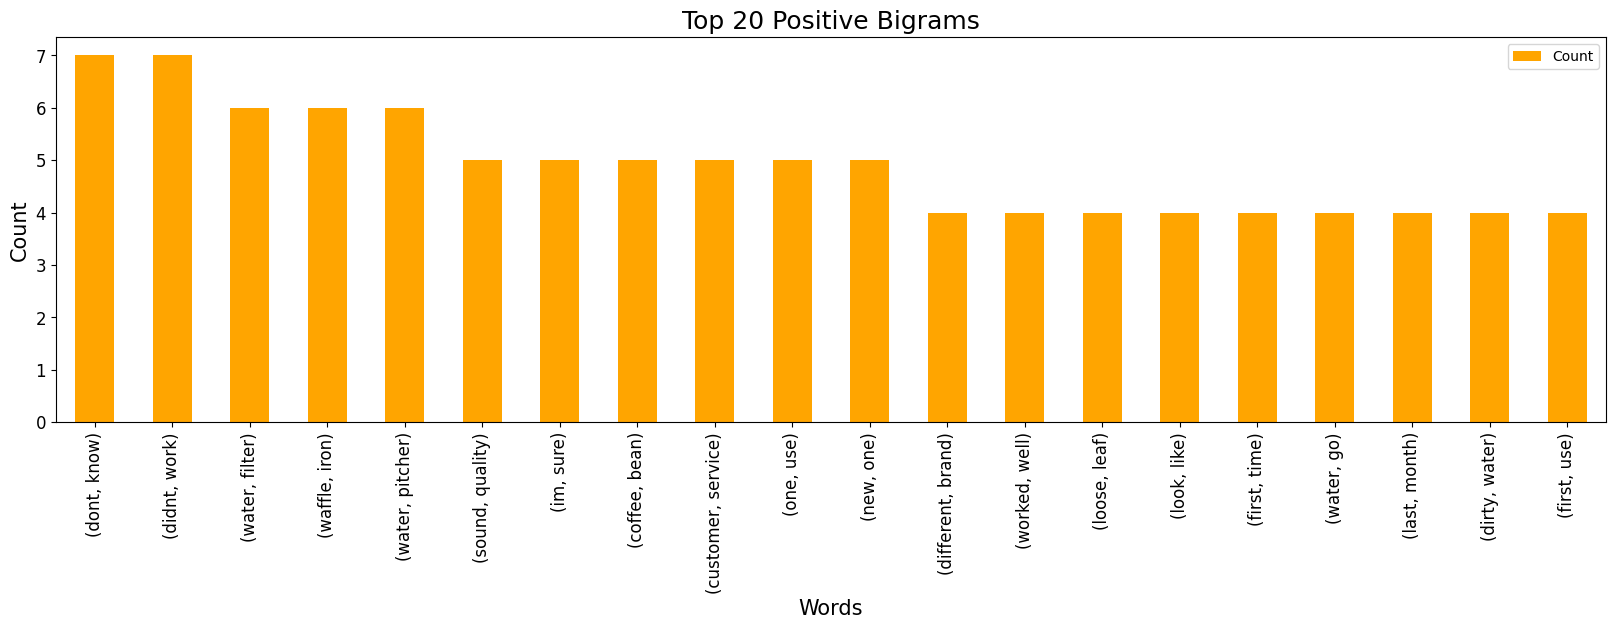

In [30]:
# Plot the df3 Bigrams frequencies

bigram_df2.head(20).plot(kind='bar', figsize=(20, 5), color="Orange")
plt.xlabel('Words', fontsize = 15)
plt.ylabel('Count', fontsize=15)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.title('Top 20 Positive Bigrams', fontsize=18)
plt.show()

## Trigram Frequency

In [35]:
# Generate trigrams from df2['Clean_review_Tokens']

trigram_list = [list(nltk.trigrams(text)) for text in negative_df['Clean_review_Tokens']]

# Create a Counter object to count the frequency of each trigram
trigram_count = collections.Counter(list(chain(*trigram_list)))

# Convert the Counter object to a DataFrame
trigram_df = pd.DataFrame.from_dict(trigram_count, orient='index').reset_index()

# Rename the columns
trigram_df = trigram_df.rename(columns={'index': 'Trigram', 0: 'Count'})

# Sort the DataFrame by frequency in descending order
trigram_df.sort_values('Count', ascending=False, inplace=True)

# Print the top 20 trigrams
trigram_df.head(20)

trigram_df1 = trigram_df.reset_index(drop=True)
trigram_df2 = trigram_df1.set_index("Trigram")
trigram_df2

,Count
Trigram,
"(hot, air, popper)",3
"(loose, leaf, tea)",3
"(grinding, coffee, bean)",2
"(water, get, filtered)",2
"(magnet, strong, enough)",2
...,...
"(business, star, american)",1
"(go, business, star)",1
"(sale, go, business)",1


In [36]:
# Storing the frequencies of unigrams

freq3 = trigram_df2['Count'].reset_index(drop=True)
print(type(freq3))
freq3

<class 'pandas.core.series.Series'>


0       3
1       3
2       2
3       2
4       2
       ..
5077    1
5078    1
5079    1
5080    1
5081    1
Name: Count, Length: 5082, dtype: int64

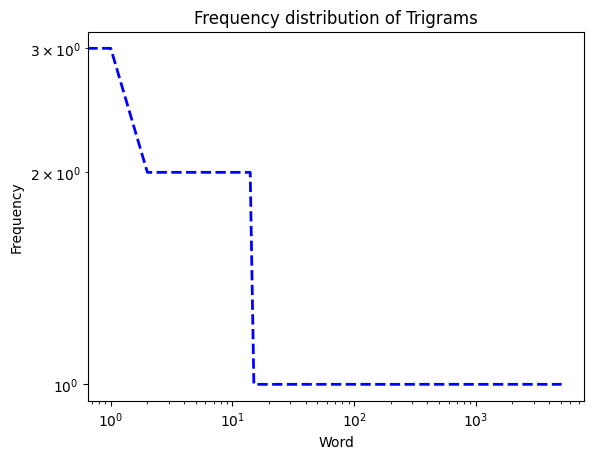

In [37]:
# Plotting the log scale of frequencies of unigrams

plt.plot(freq3, color="Blue", linewidth=2, linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.title("Frequency distribution of Trigrams")
plt.show()

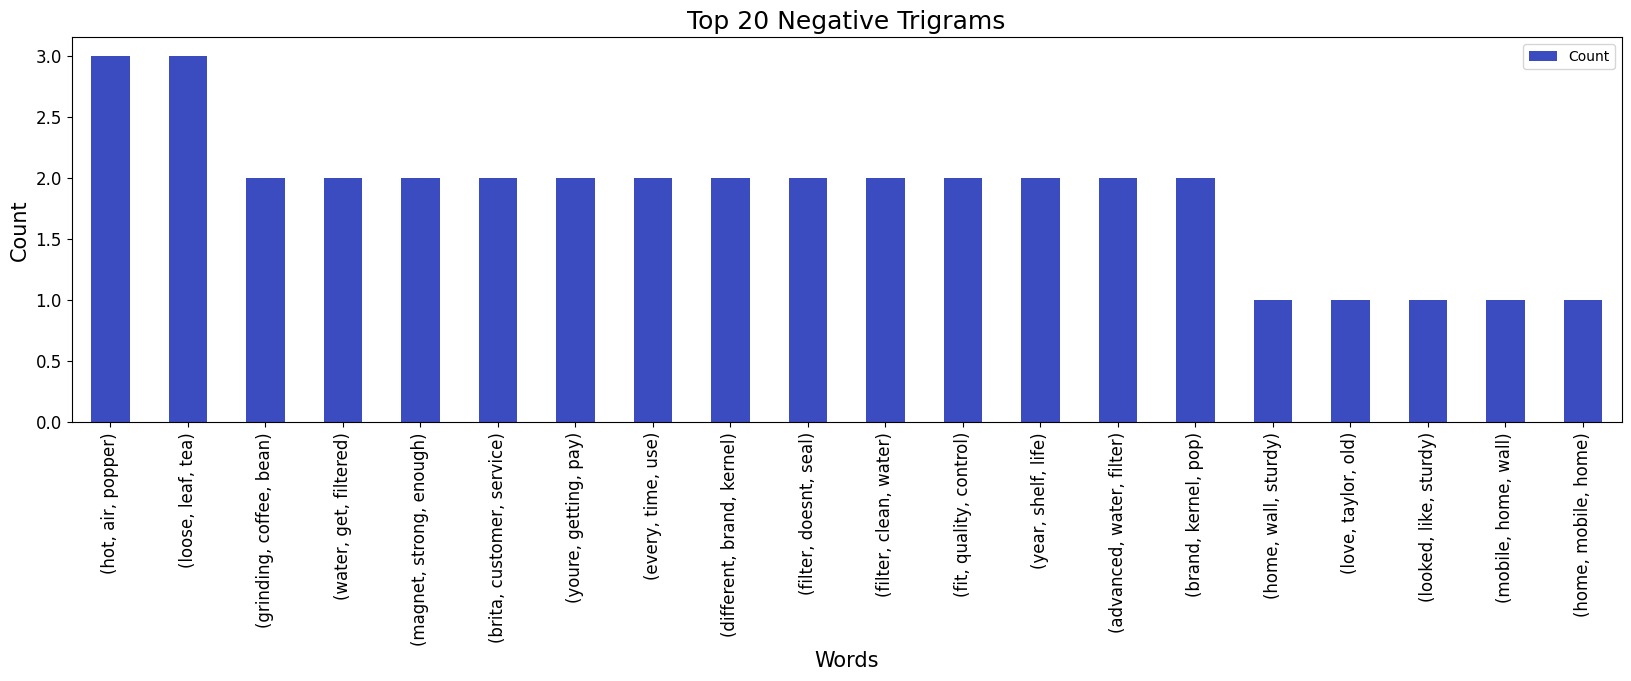

In [39]:
# Plot the top 20 Trigrams

trigram_df2.head(20).plot(kind='bar', figsize=(20, 5), cmap="coolwarm")
plt.xlabel('Words', fontsize = 15)
plt.ylabel('Count', fontsize=15)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.title('Top 20 Negative Trigrams', fontsize=18)
plt.show()

## Compare the Unigram, Bigram and Trigram token counts distributions

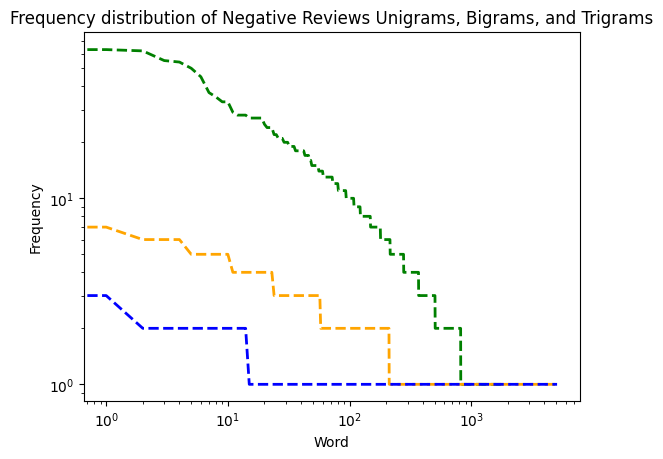

In [41]:
# Compare the Frequency distributions of Unigrams, Bigrams, and Trigrams

plt.plot(freq1, color="Green", linewidth=2, linestyle='--')
plt.plot(freq2, color="Orange", linewidth=2, linestyle='--')
plt.plot(freq3, color="Blue", linewidth=2, linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.title("Frequency distribution of Negative Reviews Unigrams, Bigrams, and Trigrams")
plt.show()


#### The graph shows the frequency distribution of token counts in unigrams, bigrams, and trigrams in the positive sentiment reviews. The x-axis represents the words and the y-axis represents the frequency of occurrence. The graph shows that unigrams are the most frequent type of token, followed by bigrams and trigrams. This is because unigrams are the smallest units of meaning, and they are more likely to occur in a sentence than bigrams or trigrams. The graph also shows that there is a long tail of low-frequency tokens, which means that there are many words that only occur once or twice in the reviews. This is not surprising, as there are a large number of possible words that can be used to express a sentiment.

## Next word prediction using LSTM

In [42]:
#Import the necessary libraries

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Dropout

## Data Pre-processing

In [43]:
# Tokenize the text data

tokenizer = Tokenizer()
tokenizer.fit_on_texts(negative_df['Clean_review_Tokens'])
total_words = len(tokenizer.word_index) + 1
print(total_words)

1917


In [48]:
# Create input sequences
input_sequences = []
for line in negative_df['Clean_review_Tokens']:
    token_list = tokenizer.texts_to_sequences([line])[0]

    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

In [ ]:
# Print input_sequences
# input_sequences

In [49]:
# Print the max sequence length

max_sequence_len = max([len(seq) for seq in input_sequences])
print(max_sequence_len)

378


In [50]:
# Pad sequences and split into predictors and label

padded_input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

print(padded_input_sequences)

[[   0    0    0 ...    0  821   37]
 [   0    0    0 ...  821   37   16]
 [   0    0    0 ...   37   16   30]
 ...
 [   0    0    0 ... 1915  123  236]
 [   0    0    0 ...  123  236 1916]
 [   0    0    0 ...  236 1916  123]]


In [47]:
# Define X and y

X = padded_input_sequences[:, :-1]
y = padded_input_sequences[:, -1]

# Print the dimensions of X and y

print("The shape of padded input sequence X is:", X.shape)
print("The shape of padded input sequence y is:", y.shape)


The shape of padded input sequence X is: (5367, 377)
The shape of padded input sequence y is: (5367,)


In [51]:
# Convert target data to one-hot encoding
y = tf.keras.utils.to_categorical(y, num_classes=total_words)

# Print the new dimensions of X and y
print("The shape of X is:", X.shape)
print("The shape of y is:", y.shape)

The shape of X is: (5367, 377)
The shape of y is: (5367, 1917)


In [55]:
# Define the model

model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(LSTM(128, return_sequences=True))
model.add((LSTM(128)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 377, 100)          191700    
                                                                 
 lstm_2 (LSTM)               (None, 377, 128)          117248    
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dense_1 (Dense)             (None, 1917)              247293    
                                                                 
Total params: 687825 (2.62 MB)
Trainable params: 687825 (2.62 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


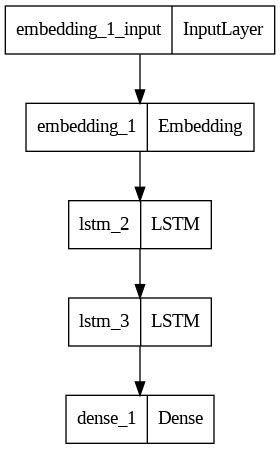

In [56]:
from tensorflow import keras
from tensorflow.keras.utils import plot_model

keras.utils.plot_model(model, to_file='model.png', show_layer_names=True)

In [57]:
#Fit the model

history = model.fit(X, y, validation_split=0.05, batch_size=128, epochs=500, shuffle=True).history

Epoch 1/500
40/40 [==============================] - 17s 226ms/step - loss: 7.3756 - accuracy: 0.0094 - val_loss: 7.3491 - val_accuracy: 0.0223
Epoch 2/500
40/40 [==============================] - 8s 195ms/step - loss: 7.0381 - accuracy: 0.0116 - val_loss: 7.4586 - val_accuracy: 0.0149
Epoch 3/500
40/40 [==============================] - 5s 136ms/step - loss: 6.9788 - accuracy: 0.0092 - val_loss: 7.5572 - val_accuracy: 0.0149
Epoch 4/500
40/40 [==============================] - 5s 138ms/step - loss: 6.9670 - accuracy: 0.0096 - val_loss: 7.5925 - val_accuracy: 0.0037
Epoch 5/500
40/40 [==============================] - 5s 113ms/step - loss: 6.9554 - accuracy: 0.0082 - val_loss: 7.6676 - val_accuracy: 0.0149
Epoch 6/500
40/40 [==============================] - 4s 91ms/step - loss: 6.9397 - accuracy: 0.0108 - val_loss: 7.6583 - val_accuracy: 0.0223
Epoch 7/500
40/40 [==============================] - 3s 76ms/step - loss: 6.8724 - accuracy: 0.0114 - val_loss: 7.8269 - val_accuracy: 0.0112


## Model Evaluation

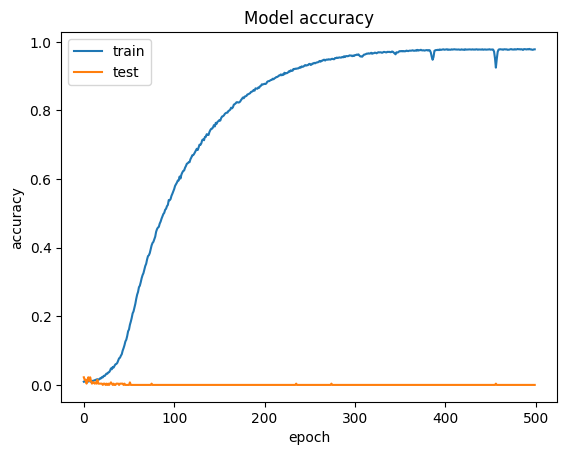

In [59]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### The model accuracy graph sugg that the training accuracy increases from 0 to 97% but the validation accuracy remains stagnant at around 0% over 500 epochs.

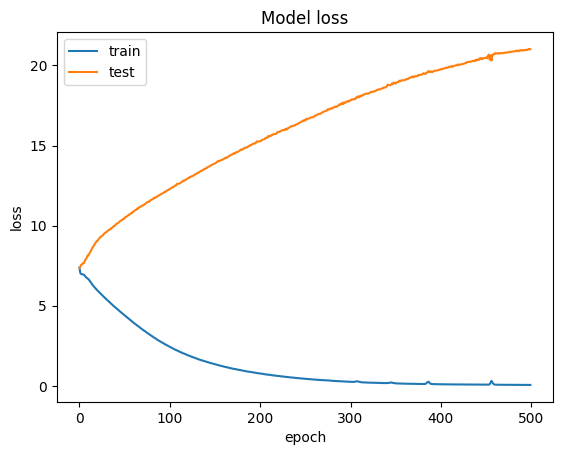

In [60]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### The model loss graph suggests that the model training loss steadily decreases over time from around 7 to 0 while the validation loss steadily increases over the number of epochs from 7 to 20.

## Model Prediction

In [62]:
import time

# text = "husband us find good arthritis stretching"

text ="tore little year im strong poor quality also"

for i in range(10):

  # tokenize
  token_text = tokenizer.texts_to_sequences([text])[0]

  # padding
  padded_token_text = pad_sequences([token_text], maxlen=377, padding='pre')

  # predict
  pos = np.argmax(model.predict(padded_token_text))

  for word,index in tokenizer.word_index.items():
    if index == pos:
      text = text + " " + word
      print(text)
      time.sleep(2)

1/1 [==============================] - 1s 611ms/step
tore little year im strong poor quality also one
1/1 [==============================] - 0s 25ms/step
tore little year im strong poor quality also one handle
1/1 [==============================] - 0s 25ms/step
tore little year im strong poor quality also one handle got
1/1 [==============================] - 0s 27ms/step
tore little year im strong poor quality also one handle got bent
1/1 [==============================] - 0s 25ms/step
tore little year im strong poor quality also one handle got bent still
1/1 [==============================] - 0s 24ms/step
tore little year im strong poor quality also one handle got bent still work
1/1 [==============================] - 0s 28ms/step
tore little year im strong poor quality also one handle got bent still work tear
1/1 [==============================] - 0s 25ms/step
tore little year im strong poor quality also one handle got bent still work tear painful
1/1 [==============================]

## Conclusion:

#### After reviewing the model performance evaluation results we can conclude that while the model training accuracy increases with the number of epochs, the validation accuracy remains stagnant and decreases with time.

#### Also, while the model training loss decreases with the number of epochs, the validation loss increases consistently increases with time which shows that the model is overfitting and is not able to generalize well on unseen data.

## Convert the file into pdf and html format

In [64]:
%%shell
jupyter nbconvert --to html ///content/HW2_RNN_Negative_Reviews.ipynb

[NbConvertApp] Converting notebook ///content/HW2_RNN_Negative_Reviews.ipynb to html
[NbConvertApp] Writing 1339577 bytes to /content/HW2_RNN_Negative_Reviews.html
